In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as cnt
from scipy.signal import savgol_filter

In [3]:
def calc_U_Plasma(df, ax=None):
    window_size = 30
    polyorder = 2
    I = savgol_filter(df['I'].values, window_size, polyorder)
    dI_dU = np.gradient(I, df['U'])
    max_index = dI_dU.argmax()
    u_plasma = df['U'].iloc[max_index]
    if ax is not None:
        ax.plot(df['U'], dI_dU)
        ax.axvline(u_plasma, label='$U_\\mathrm{P}$')
    return u_plasma
def GetSmoothedZeroIndex(data, window_size = 40):
    window_size = 40
    smoothed_data = data.rolling(window_size, center=True).mean()
    return smoothed_data.abs().idxmin()

def calc_U_Float(df, ax=None):
    i_floating_pot = GetSmoothedZeroIndex(df['I'])

    floating_region_start = i_floating_pot - 20
    floating_region_end = i_floating_pot + 20

    floating_voltage = df['U'].loc[floating_region_start:floating_region_end]
    floating_current = df['I'].loc[floating_region_start:floating_region_end]

    slope, intercept = np.polyfit(floating_voltage, floating_current, 1)
    floating_potential = - intercept / slope
    if ax is not None:
        ax.axvline(floating_potential, label='$U_\\mathrm{F}$')
    return floating_potential

def calc_I_Ion_Sat(df, floating_potential, ax=None):
    i_floating_pot = df['U'].sub(floating_potential).abs().idxmin()
    slope, intercept = np.polyfit(df['U'].loc[0 : i_floating_pot], df['I'].loc[0 : i_floating_pot], 1)
    i_ion_sat = intercept + slope * (df['U'][i_floating_pot] -3.5)
    if ax is not None:
        ax.axhline(i_ion_sat)
    return i_ion_sat

def calc_T_e(df, plasma_potential, floating_potential, ax=None):
    i_plasma_potential  = df['U'].sub(plasma_potential).abs().idxmin()
    i_floating_potential = df['U'].sub(floating_potential).abs().idxmin()
    electron_transistion_region_size = i_plasma_potential - i_floating_potential
    region_start = int(i_floating_potential + 0.4 * electron_transistion_region_size)
    region_end = int(i_plasma_potential)

    def exponential_func(x, a, b):
        return   a * np.exp(-b * x)

    params, params_covariance = curve_fit(exponential_func,
                                            df['U'].loc[region_start:region_end],
                                            df['I'].loc[region_start:region_end], maxfev=100000)

    if ax is not None:
        ax.axvspan(df['U'][region_start], df['U'][region_end], color='red', alpha=0.1)
        us = np.linspace(df['U'][region_start], df['U'][region_end], 1000)
        ax.plot(us, exponential_func(us, *params), 'r--')
    return - cnt.e / (cnt.k * params[1])

def calc_I_e_sat(df, plasma_potential, floating_potential, ax = None):
    i_plasma_potential  = df['U'].sub(plasma_potential).abs().idxmin()
    i_floating_potential = df['U'].sub(floating_potential).abs().idxmin()
    electron_transistion_region_size = i_plasma_potential - i_floating_potential
    region_start = int(i_plasma_potential + 0.5 * electron_transistion_region_size)
    def exponential_func(x, a, b, c):
        return  a * np.exp(-b * (x)) + c

    params, params_covariance = curve_fit(exponential_func,
                                          df['U'].loc[region_start:],
                                          df['I'].loc[region_start:], maxfev=100000)
    i_e_sat = exponential_func(plasma_potential, *params)
    if ax is not None:
        ax.axvspan(df['U'][region_start], df['U'].iloc[-1], color='green', alpha=0.1)
        us = np.linspace(df['U'][region_start], df['U'].iloc[-1], 1000)
        ax.plot(us, exponential_func(us, *params), 'g--')
        ax.axhline(i_e_sat)
    return i_e_sat


In [4]:
def calc_plasma_parameters(df, discharge_current, ax = None):
    U_p = calc_U_Plasma(df, ax)
    U_f = calc_U_Float(df, ax)
    I_i_sat = calc_I_Ion_Sat(df, U_f, ax)
    I_e_sat = calc_I_e_sat(df, U_p, U_f, ax)
    T_e = calc_T_e(df, U_p, U_f, ax)

    A = 9.2 * (1e-3)**2

    n_e = 4 * I_e_sat / (cnt.e * A) * np.sqrt(np.pi * cnt.m_e / (8 * cnt.k * T_e))
    n_i = abs(I_i_sat) / (0.61 * cnt.e * A) * np.sqrt(40 * cnt.u / (cnt.k * T_e))
    lambda_d = np.sqrt(cnt.epsilon_0 * cnt.k * T_e / (cnt.e ** 2 * n_e))
    omega_p = np.sqrt(cnt.e **2 * n_e / (cnt.epsilon_0 * cnt.m_e))
    alpha = n_e * cnt.k * 300 / 100

    #T_e_2 = cnt.e * (floating_potential - plasma_potential) / (cnt.k * np.log(0.61 * np.sqrt(2 * np.pi * cnt.m_e / (40 * cnt.u))))

    return pd.DataFrame({
        'Discharge Current': [discharge_current],
        'Plasma Potential': [U_p],
        'Floating Potential': [U_f],
        'Ion Saturation Current': [I_i_sat],
        'Electron Temperature': [T_e],
        'Electron Saturation Current': [I_e_sat],
        #'Electron Temperature 2': [T_e_2],
        'Electron Density': [n_e],
        'Ion Density': [n_i],
        'Debye Length': [lambda_d],
        'Plasma Frequency': [omega_p],
        'Ionisation Degree': [alpha]
    })

In [5]:
data = np.loadtxt('data/Kennlinie_Anode_GND/71_6.txt', skiprows=3)
offset = 300
U = data[offset:,0]
I = data[offset:, 1]

In [6]:
import os
folder_path = 'data/Kennlinie_Anode_GND'  # Replace with the actual folder path
df = pd.DataFrame()
filenames = filter(lambda f: os.path.isfile(os.path.join(folder_path, f)), os.listdir(folder_path))
#filenames = [next(filenames, None)]

for filename in filenames:
    file_path = os.path.join(folder_path, filename)
    file_df = pd.read_csv(file_path, skiprows=3, header=None, delimiter='\t')
    file_df.columns = ['U', 'I']
    file_df['I_discharge'] = float(filename.replace('.txt', '').replace('_', '.'))
    df = pd.concat([df, file_df], ignore_index=True)

In [7]:
plasma_parameters = pd.DataFrame(columns=['Discharge Current', 'Plasma Potential', 'Floating Potential', 'Ion Saturation Current'])
for discharge_current, group in df.groupby('I_discharge'):
    #fig, ax = plt.subplots()
    #ax.plot(group['U'], group['I'], lw=.5)
    plasma_parameters = pd.concat([plasma_parameters, calc_plasma_parameters(group, discharge_current)], ignore_index=True)
    #ax.set_yscale('log')
    #ax.legend()

latex_table = plasma_parameters.style.to_latex()
# Save the LaTeX table to a file
file_path = 'out/plasma_params.tex'  # Specify the file path
with open(file_path, 'w') as f:
    f.write(latex_table)

plasma_parameters

,Discharge Current,Plasma Potential,Floating Potential,Ion Saturation Current,Electron Temperature,Electron Saturation Current,Electron Density,Ion Density,Debye Length,Plasma Frequency,Ionisation Degree
0,31.8,-6.0890,-8.877695,-3.987446e-07,6988.691236,0.000226,1.180098e+15,3.679440e+14,0.000168,1.937986e+09,4.887903e-08
1,40.8,-5.5635,-8.239345,-3.852349e-07,6594.298355,0.000227,1.218680e+15,3.659538e+14,0.000161,1.969411e+09,5.047709e-08
2,50.7,-4.7935,-7.447107,-3.737635e-07,6319.462833,0.000235,1.293796e+15,3.626950e+14,0.000153,2.029198e+09,5.358834e-08
3,60.3,-4.2050,-6.919939,-3.617625e-07,6155.925435,0.000253,1.407920e+15,3.556819e+14,0.000144,2.116803e+09,5.831530e-08
4,69.8,-3.8690,-6.522153,-3.748554e-07,5976.957326,0.000268,1.514968e+15,3.740318e+14,0.000137,2.195802e+09,6.274917e-08
5,71.6,-3.7500,-6.406390,-3.725475e-07,5920.842095,0.000274,1.552898e+15,3.734864e+14,0.000135,2.223120e+09,6.432021e-08


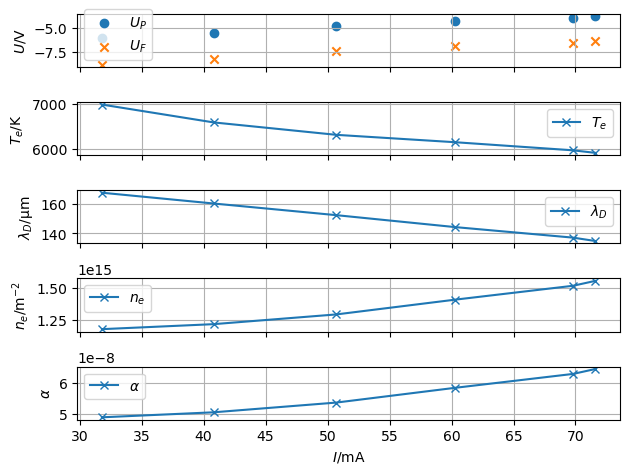

In [8]:
fig, axs = plt.subplots(5, sharex=True)
axs[0].scatter(plasma_parameters['Discharge Current'], plasma_parameters['Plasma Potential'], label='$U_P$')
axs[0].scatter(plasma_parameters['Discharge Current'], plasma_parameters['Floating Potential'],label='$U_F$', marker='x')
axs[0].grid()
axs[0].legend()
axs[0].set(ylabel="$U / \\mathrm{V}$")

axs[1].plot(plasma_parameters['Discharge Current'], plasma_parameters['Electron Temperature'], label='$T_e$', marker='x')
axs[1].set(ylabel="$T_e / \\mathrm{K}$")
axs[1].grid()
axs[1].legend()

axs[2].plot(plasma_parameters['Discharge Current'], plasma_parameters['Debye Length'] *1e6, label='$\lambda_D$', marker='x')
axs[2].set(ylabel="$\lambda_D / \\mathrm{\mu m}$")
axs[2].grid()
axs[2].legend()

axs[3].plot(plasma_parameters['Discharge Current'], plasma_parameters['Electron Density'], label='$n_e$', marker='x')
axs[3].set(ylabel="$n_e / \\mathrm{m^{-2}}$")
axs[3].grid()
axs[3].legend()

axs[4].plot(plasma_parameters['Discharge Current'], plasma_parameters['Ionisation Degree'], label='$\\alpha$', marker='x')
axs[4].set(ylabel="$\\alpha$")
axs[4].grid()
axs[4].legend()

axs[-1].set(xlabel="$I / \\mathrm{mA}$")

fig.tight_layout()


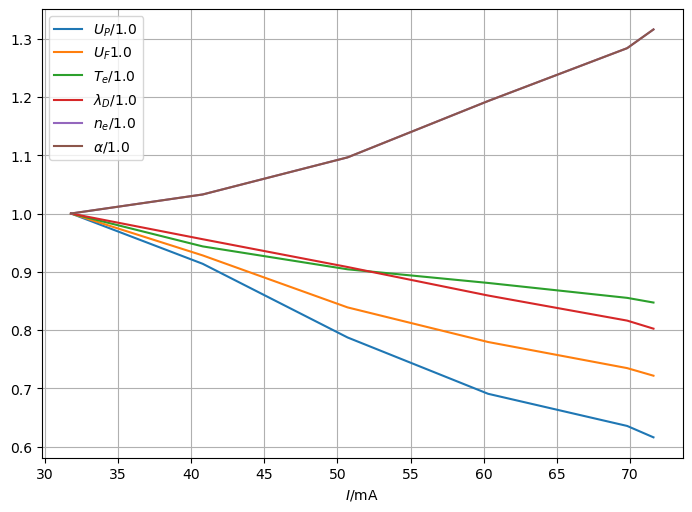

In [20]:
fig, ax=plt.subplots(figsize=(8.26772,5.82677))

plotlist=[plasma_parameters['Plasma Potential'],plasma_parameters['Floating Potential'],plasma_parameters['Electron Temperature'],plasma_parameters['Debye Length'],plasma_parameters['Electron Density'],plasma_parameters['Ionisation Degree']]
for y in plotlist:
    yplt=y/y[0]
    ax.plot(plasma_parameters['Discharge Current'],y)
ax.legend(['$U_P/'+str(plotlist[0][0])+'$','$U_F'+str(plotlist[0][0])+'$','$T_e/'+str(plotlist[0][0])+'$','$\lambda_D/'+str(plotlist[0][0])+'$','$n_e/'+str(plotlist[0][0])+'$','$\\alpha/'+str(plotlist[0][0])+'$'])
ax.set_xlabel("$I / \\mathrm{mA}$")
ax.grid()